In [1]:
import metaworld
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

# stop warnings
warnings.filterwarnings('ignore')

# from models import encoder, policy
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
RUN_FOLDER = './logs/logs_ML10-v2/rl2_73__25:10_21:13:08'
policy_net = torch.load(RUN_FOLDER + '/models/policy.pt')
encoder_net = torch.load(RUN_FOLDER + '/models/encoder.pt')

In [9]:
class Agent:

    def __init__(self, encoder, policy):
        self.encoder = encoder
        self.policy = policy

    def _process_latent(self, latent_sample, latent_mean, latent_logvar):
        # always get nonlinearities
        latent_sample = F.relu(latent_sample)
        latent_mean = F.relu(latent_mean)
        latent_logvar = F.relu(latent_logvar)
        latent = torch.cat((latent_mean, latent_logvar), dim=-1).reshape(1, -1)
        return latent
          

    def get_prior_latent(self):

        latent_sample, latent_mean, latent_logvar, hidden_state = self.encoder.prior(1)

        latent = self._process_latent(latent_sample, latent_mean, latent_logvar)

        return latent, hidden_state
    
    def update_latent(self, states, actions, rewards, hidden_state):
        ### Get updated latents
        latent_sample, latent_mean, latent_logvar, hidden_state = self.encoder(
            actions = actions.float(),
            states = torch.from_numpy(np.append(states, 0)).float()[None,].to(device),
            rewards = torch.from_numpy(np.array(rewards)).float()[None,None,].to(device),
            hidden_state=hidden_state,
            return_prior=False
        )

        latent = self._process_latent(latent_sample, latent_mean, latent_logvar)

        return latent, hidden_state

    def evaluate(self, num_episodes, environments: dict):

        # dict to log results
        episode_log = {env_name:{'episode_len': [],'episode_reward': [], 'successes':[]} \
               for env_name in environments.keys()}
        
        # evaluation loop across all environments
        for env_name, env, in environments.items():

            # reset encoder to prior
            latent, hidden_state = self.get_prior_latent()

            for episode in range(num_episodes):
                obs, _ = env.reset()

                done = False
                episode_reward = 0
                episode_steps = 0
                success = 0

                while not done:

                    _, act = self.policy.act(obs, latent, None, None)
                    action = act.cpu().detach().numpy()[0]

                    next_obs, reward, terminated, truncated, info = env.step(action)
                    obs = next_obs
                    done = terminated or truncated
                    episode_reward += reward
                    episode_steps += 1
                    success = 1 if info['success']==1 else 0

                    latent, hidden_state = self.update_latent(obs, act, reward, hidden_state)

                episode_log[env_name]['episode_reward'].append(episode_reward / episode_steps)
                episode_log[env_name]['episode_len'].append(episode_steps)
                episode_log[env_name]['successes'].append(success)

        return episode_log



In [10]:
def unpack_df(df):
    return pd.concat(
        [pd.DataFrame(dict(zip(df.columns, df.iloc[i]))) for i in range(len(df))]
        )

def process_episode_log(episode_log):
    # process data
    df = pd.DataFrame(episode_log)

    # get rewards
    rewards = unpack_df(df.loc[df.index=='episode_reward', :])
    rewards.loc[:,'iter'] = rewards.index
    rewards = rewards.melt(id_vars = 'iter')

    # get successes
    successes = unpack_df(df.loc[df.index=='successes', :])
    successes.loc[:, 'iter'] = successes.index
    successes = successes.melt(id_vars = 'iter')
    successes = successes.groupby(['variable']).agg(lambda x: 100 * sum(x)/len(x)).reset_index()

    return rewards, successes

def plot_results(episode_log):
    rewards, successes = process_episode_log(episode_log)

    fig, ax = plt.subplots(1,2, figsize = (15, 7))

    bplot = sns.barplot(
        data = successes.reset_index(),
        x = 'variable',
        y = 'value',
        ax = ax[0]
    );

    bplot.set_xticklabels(
        bplot.get_xticklabels(),
        rotation = 90
    );

    bplot.set_title('Percentage of Successes by Task');

    lplot = sns.lineplot(
        data = rewards,
        x = 'iter',
        y = 'value',
        hue='variable'
    );

    lplot.set_title('Rewards by Task');

    

In [11]:
def build_env_dict(metaworld_benchmark):
    training_envs = dict()
    for name, env_cls, in metaworld_benchmark.train_classes.items():
        env = env_cls()
        task = random.choice([task for task in metaworld_benchmark.train_tasks
                              if task.env_name == name])
        env.set_task(task)
        training_envs[name] = env

    testing_envs = dict()
    for name, env_cls, in metaworld_benchmark.test_classes.items():
        env = env_cls()
        task = random.choice([task for task in metaworld_benchmark.test_tasks
                              if task.env_name == name])
        env.set_task(task)
        testing_envs[name] = env
    
    return training_envs, testing_envs

In [12]:
ml10 = metaworld.ML10() # Construct the benchmark, sampling tasks

training_envs, testing_envs = build_env_dict(ml10)


In [13]:
agent = Agent(encoder_net, policy_net)

train_log = agent.evaluate(10, training_envs)
test_log = agent.evaluate(10, testing_envs)

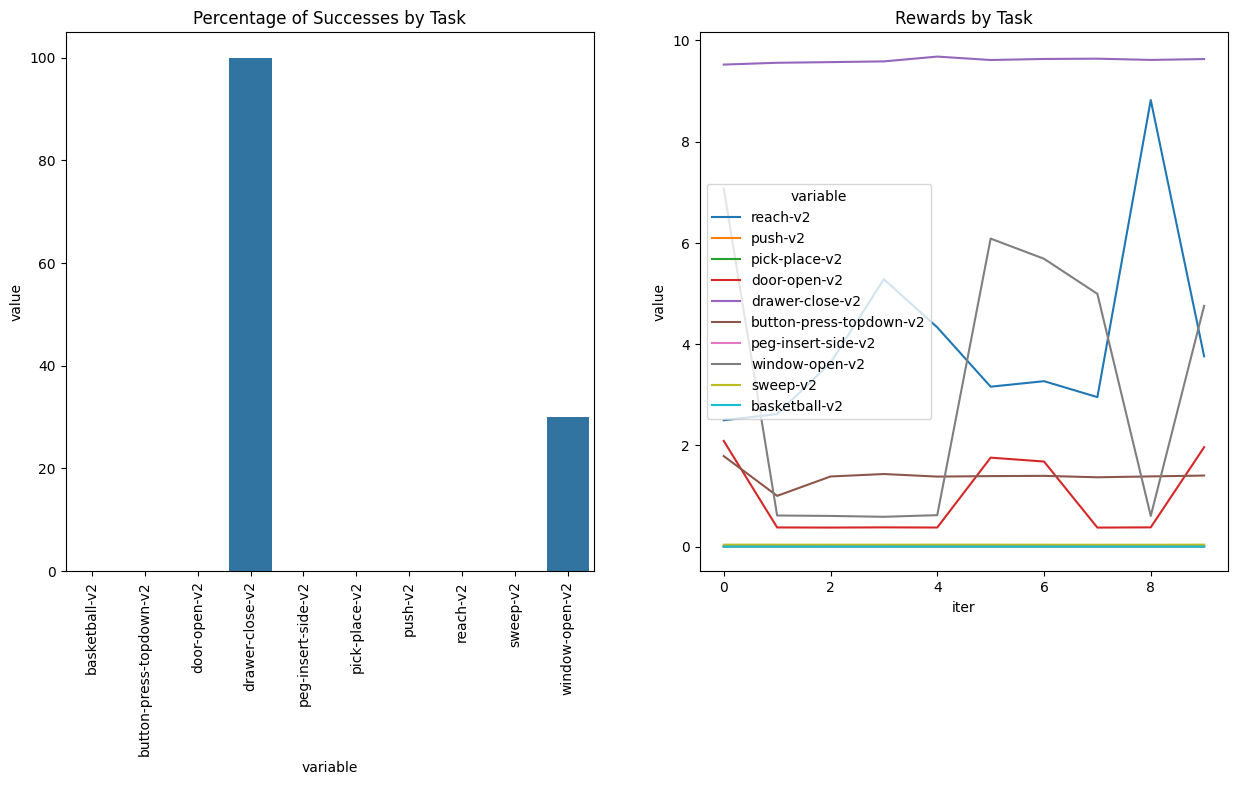

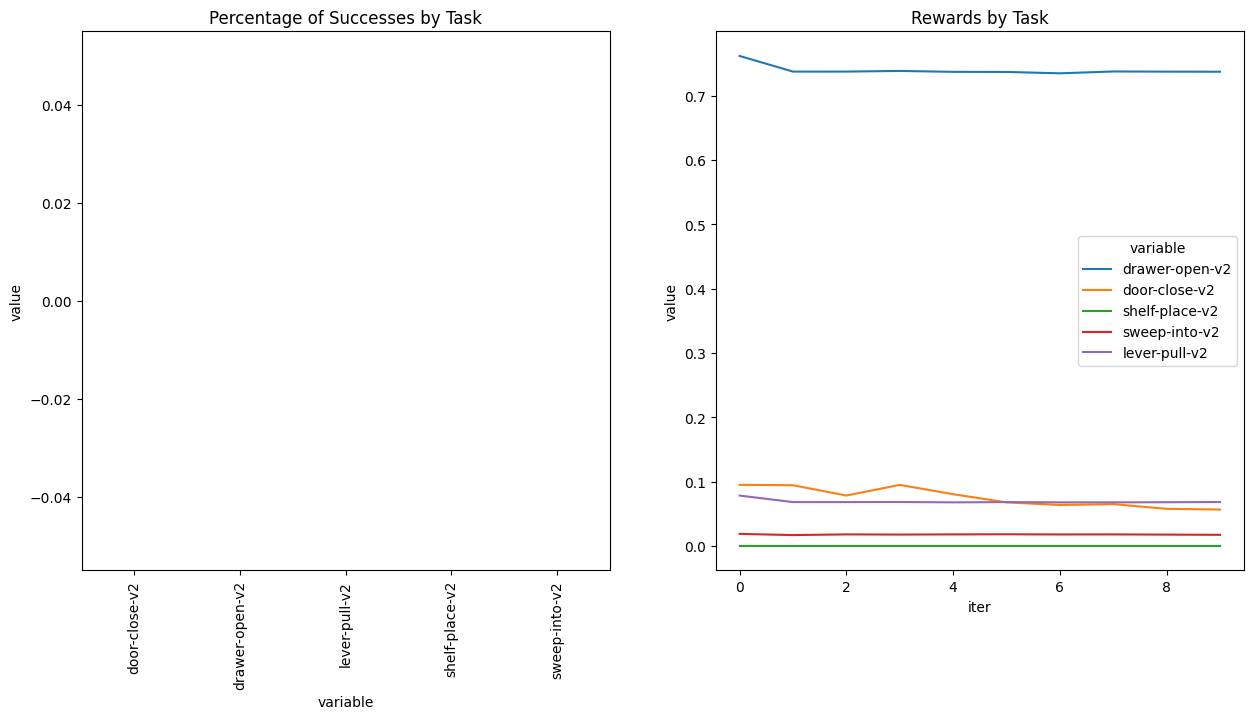

In [14]:
plot_results(train_log)
plot_results(test_log)